In [ ]:
#|default_exp sgd

# Experiment with Saliency Maps

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

## Dig in autograd and the graph

- https://pytorch.org/blog/overview-of-pytorch-autograd-engine/
- http://blog.ezyang.com/2019/05/pytorch-internals/
- https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/


- https://pytorch.org/docs/stable/autograd.html#


In [ ]:
def tensor_info(t):
    print(f"Shape:........ {t.shape}")
    print(f"On:........... {t.device}")
    print(f"Requires grad: {t.requires_grad}")
    print(f"Is a leaf:.... {t.is_leaf} \n")

In [ ]:
x = torch.tensor([0.5, 0.75], requires_grad=True)
tensor_info(x)

Shape:........ torch.Size([2])
On:........... cpu
Requires grad: True


In [ ]:
y = torch.log(x[0] * x[1]) * torch.sin(x[1])
tensor_info(y)

Shape:........ torch.Size([])
On:........... cpu
Requires grad: True


In [ ]:
x.is_leaf

True

In [ ]:
y.backward(inputs=x)

In [ ]:
x.grad

tensor([1.36, 0.19])

Inspect all custom tensors

In [ ]:
objects = [(n, globals()[n]) for n in dir() if '_' not in n[:2]]
tensors = [(n, o) for (n, o) in objects if isinstance(o, torch.Tensor) ]
print(f"{len(tensors)} active tensors")
for n, t in tensors:
    print(n)
    tensor_info(t)
    print(t.is_leaf, '\n')

del t

2 active tensors
x
Shape:........ torch.Size([2])
On:........... cpu
Requires grad: True
True 

y
Shape:........ torch.Size([])
On:........... cpu
Requires grad: True
False 



In [ ]:
del x, y

## Load data

Load fashion MNIST and create data loaders

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean, xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

## Train model (Momentum)

In [ ]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1

    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [ ]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom=mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= self.lr * p.grad_avg

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.786,0.592,0,train
0.849,0.415,0,eval
0.872,0.351,1,train
0.863,0.364,1,eval
0.887,0.309,2,train
0.874,0.344,2,eval


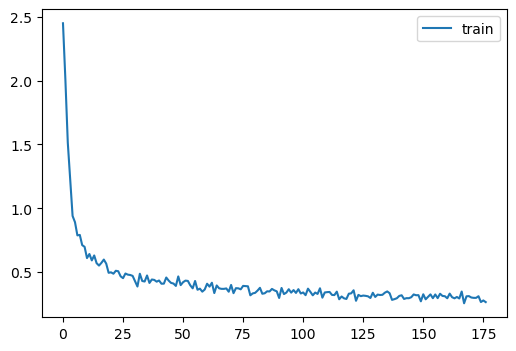

In [ ]:
learn.fit(3)

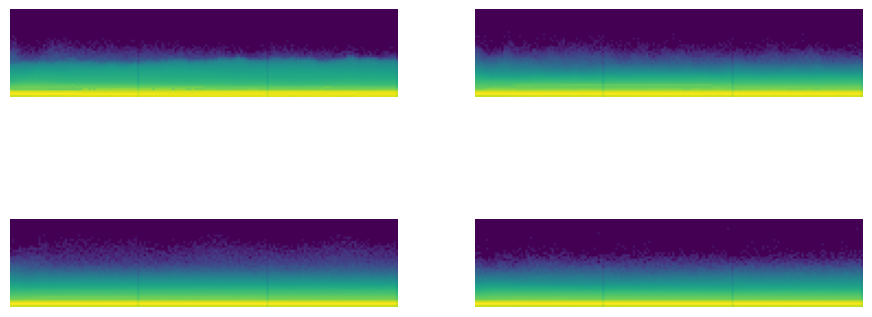

In [ ]:
astats.color_dim()

## Saliency maps

### Experiments

Based on [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034)

In [ ]:
objects = [(n, globals()[n]) for n in dir() if '_' not in n[:2]]
tensors = [(n, o) for (n, o) in objects if isinstance(o, torch.Tensor) ]
print(f"{len(tensors)} active tensors")
for n, t in tensors:
    print(n)
    tensor_info(t)

try: del t
except: pass

5 active tensors
images
Shape:........ torch.Size([2, 1, 28, 28])
On:........... cuda:0
Requires grad: True
Is a leaf:.... True 

img
Shape:........ torch.Size([1, 1, 28, 28])
On:........... cuda:0
Requires grad: True
Is a leaf:.... False 

preds
Shape:........ torch.Size([1, 10])
On:........... cuda:0
Requires grad: True
Is a leaf:.... False 

xb
Shape:........ torch.Size([2, 1, 28, 28])
On:........... cpu
Requires grad: False
Is a leaf:.... True 

yb
Shape:........ torch.Size([2])
On:........... cpu
Requires grad: False
Is a leaf:.... True 



Select a few images and prepare them to calculate saliency map:
- pick images
- set `requires_grad` to `True` for the input
- move input images to GPU

In [ ]:
n = 2
xb, yb = next(iter(dls.train))
xb, yb = xb[0:n, :, :, :], yb[0:n]

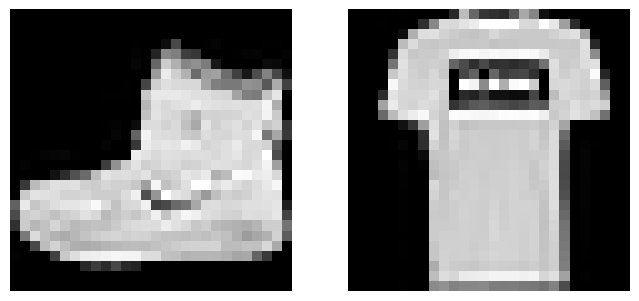

In [ ]:
_, axs = plt.subplots(nrows=1, ncols=n, figsize=(8, 4))
for ax, img in zip(axs.flatten(), xb[:4]):
    show_image(img, ax=ax, cmap='gray' )

In [ ]:
# print(torch.cuda.memory_summary()) 

In [ ]:
images = xb.clone().to(device='cuda')
images.requires_grad_();

In [ ]:
tensor_info(images)

Shape:........ torch.Size([2, 1, 28, 28])
On:........... cuda:0
Requires grad: True
Is a leaf:.... True 



Generate saliency map for each selecte image:
- evaluate the predictions (logits) for selected image (forward pass)
- pick the largest logit (output that will be the base for saliency map)
- back propagate the logit through the model to the input image
- extract input gradient and plot

In [ ]:
i = 0
img = images[i:i+1, :, :, :]
tensor_info(img)

Shape:........ torch.Size([1, 1, 28, 28])
On:........... cuda:0
Requires grad: True
Is a leaf:.... False 



In [ ]:
preds = learn.model(images[i:i+1, :, :, :])
tensor_info(preds)

Shape:........ torch.Size([1, 10])
On:........... cuda:0
Requires grad: True
Is a leaf:.... False 



In [ ]:
cat_idx = preds.argmax(dim=1).requires_grad_(requires_grad=False)
tensor_info(cat_idx)

Shape:........ torch.Size([1])
On:........... cuda:0
Requires grad: False
Is a leaf:.... True 



In [ ]:
# end_point = preds[0, cat_idx]
end_point = preds[0, 0]
tensor_info(end_point)

Shape:........ torch.Size([])
On:........... cuda:0
Requires grad: True
Is a leaf:.... False 



In [ ]:
end_point.backward()

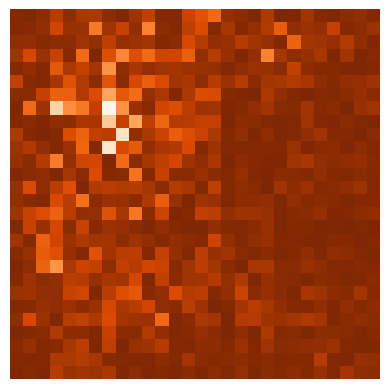

In [ ]:
saliency_map = images.grad[i].cpu().abs()
show_image(saliency_map, cmap='Oranges_r');

In [ ]:
min_v, max_v = saliency_map.min(), saliency_map.max()
min_v, max_v

(tensor(    0.00), tensor(0.94))

In [ ]:
def normalize_image(im):
    min_v, max_v = im.min(), im.max()
    return (im - min_v) / (max_v - min_v)

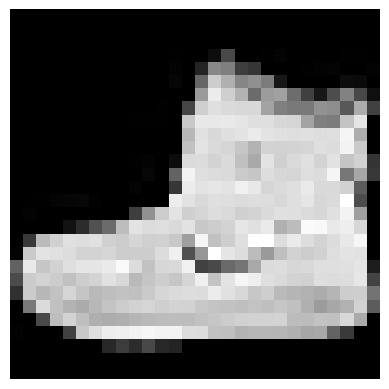

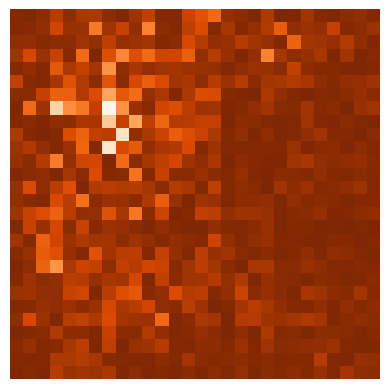

In [ ]:
sm_norm = normalize_image(saliency_map)
img_ref = normalize_image(xb[i])
show_image(img_ref, cmap='gray')
show_image(sm_norm, cmap='Oranges_r');

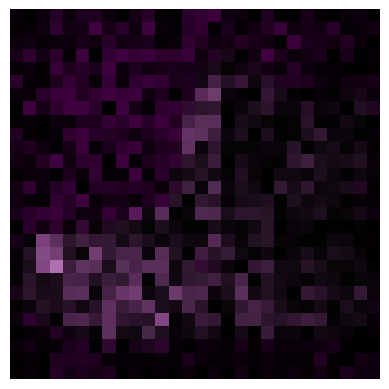

In [ ]:
from PIL import Image
import numpy as np

def saliency_over_image(im, sm, ax=None, return_images=False):

    if isinstance(im, torch.Tensor):
        im = normalize_image(im) * 255
        im = Image.fromarray(im.permute(1,2,0)[:,:,0].numpy().astype(np.uint8), mode='L')
    im = im.convert(mode='RGBA')

    if isinstance(sm, torch.Tensor):
        sm = normalize_image(sm) * 255
        sm_tnsr = torch.zeros(size=(4,28,28), dtype=sm.dtype) * 255
        sm_tnsr[0,:,:] = sm
        sm_tnsr[2,:,:] = sm
        sm_tnsr[3,:,:] = 255 - sm
        sm = Image.fromarray(sm_tnsr.permute(1,2,0).numpy().astype(np.uint8), mode='RGBA')
    
    composite_im = Image.alpha_composite(im, sm)
    
    if ax is None:
        _, ax = plt.subplots(1,1)
    ax.imshow(composite_im)
    ax.axis('off')

    if ax is None:   # to avoid that the subplots ends after one ax in case this function is in a loop
        plt.show()

    if return_images:
        return composite_im, im, sm

composite, im, sm = saliency_over_image(xb[i], saliency_map, return_images=True)

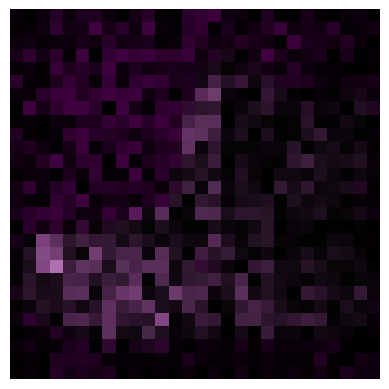

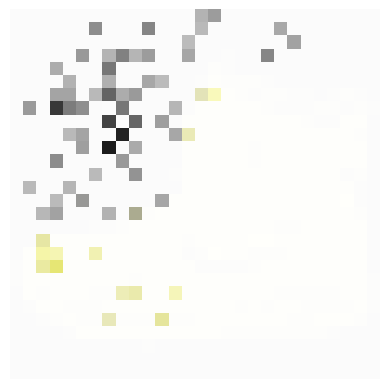

In [ ]:
def transparent_saliency(im, sm, g=1, ax=None, return_images=False):
    
    im = normalize_image(im) * 255
    sm = normalize_image(sm) * 255
    sm[sm < 64] = 0
    
#     plt.hist(sm.cpu().numpy().flatten(), bins=10, density=False, cumulative=True)
#     plt.show()

    im_tnsr = torch.zeros(size=(4,28,28), dtype=sm.dtype) * 255
    im_tnsr[0,:,:] = im
    im_tnsr[1,:,:] = im
#     im_tnsr[2,:,:] = im
    im_tnsr[3,:,:] = sm * g  + 4
    im_out = Image.fromarray(im_tnsr.permute(1,2,0).numpy().astype(np.uint8), mode='RGBA')
        
    if ax is None:
        _, ax = plt.subplots(1,1)

    ax.imshow(im_out)
    ax.axis('off')

    if ax is None:   # to avoid that the subplots ends after one ax in case this function is in a loop
        plt.show()

    if return_images:
        return im_out

saliency_over_image(xb[i], saliency_map)
im_out = transparent_saliency(xb[i], saliency_map, g=1, return_images=True)

### Show saliency as a function

In [ ]:
n = 8
xb, yb = next(iter(dls.train))
xb, yb = xb[0:n, :, :, :], yb[0:n]

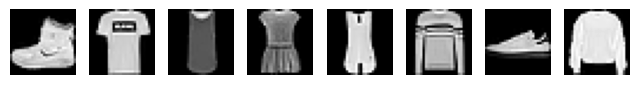

In [ ]:
_, axs = plt.subplots(nrows=1, ncols=n, figsize=(8, n))
for ax, img in zip(axs.flatten(), xb[:n]):
    show_image(img, ax=ax, cmap='gray' )

https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging

`'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu','RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic'`

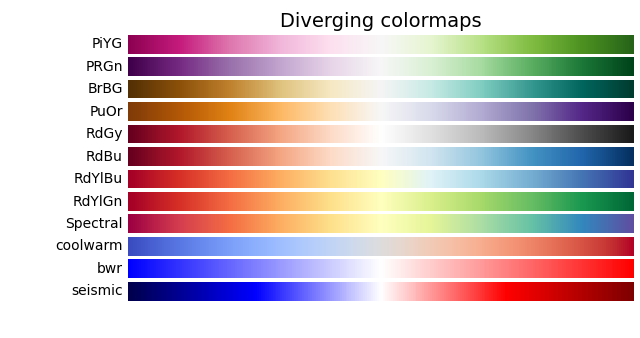

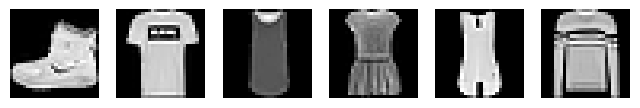

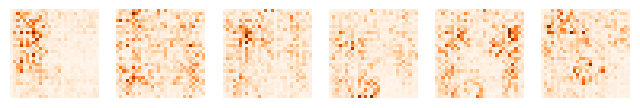

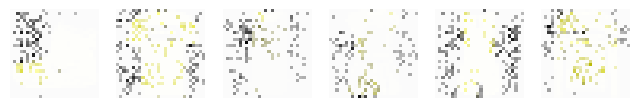

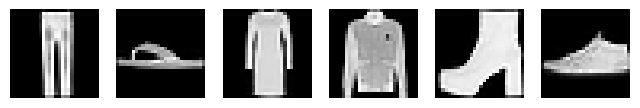

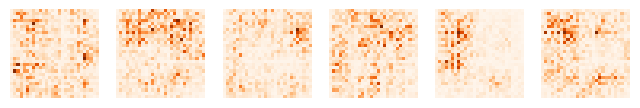

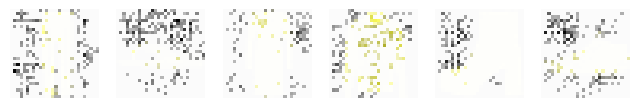

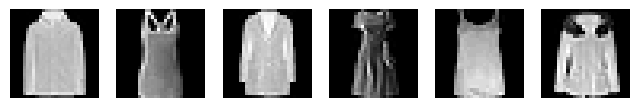

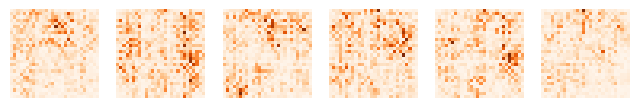

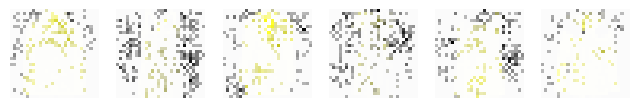

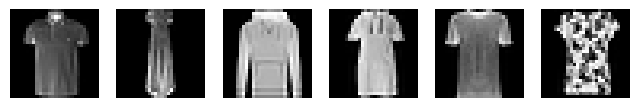

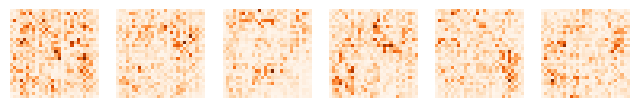

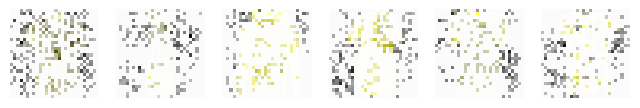

In [ ]:
def show_saliency_maps(xb, model, max_n_batches=4, n_imgs=6, cmap='seismic', abs_val=True):
    
    for i, (xb, yb) in enumerate(dls.train):
        if i >= max_n_batches: 
            break
        else:
            saliency_maps = []
            for i in range(n_imgs):
                images = xb.clone().to(device='cuda')
                images.requires_grad_();
                preds = model(images[i:i+1, :, :, :])
                cat_idx = preds.argmax(dim=1).requires_grad_(requires_grad=False)
                end_point = preds[0, cat_idx]
                end_point.backward()
                if abs_val:
                    saliency_maps.append(images.grad[i].abs())
                else:
                    saliency_maps.append(images.grad[i])

            _, axs = plt.subplots(nrows=1, ncols=n_imgs, figsize=(8, n_imgs))
            for ax, img in zip(axs.flatten(), xb[:n_imgs]):
                show_image(img, ax=ax, cmap='gray' )
            plt.show()

            _, axs = plt.subplots(nrows=1, ncols=n_imgs, figsize=(8, n_imgs))
            for ax, sm in zip(axs.flatten(), saliency_maps):
                show_image(sm, ax=ax, cmap=cmap)
            plt.show()
            
            _, axs = plt.subplots(nrows=1, ncols=n_imgs, figsize=(8, n_imgs))
            for ax, img, sm in zip(axs.flatten(), xb[:n_imgs], saliency_maps):
                # saliency_over_image(im, sm, ax=ax)
#                 transparent_saliency(img, sm, g=1)
                transparent_saliency(img, sm, g=1, ax=ax)
            plt.show()            
        
show_saliency_maps(xb, learn.model,  max_n_batches=4, n_imgs=6, cmap='Oranges', abs_val=True)

### Adam

In [ ]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

accuracy,loss,epoch,train
0.792,0.579,0,train
0.842,0.424,0,eval
0.868,0.362,1,train
0.862,0.376,1,eval
0.886,0.314,2,train
0.871,0.345,2,eval


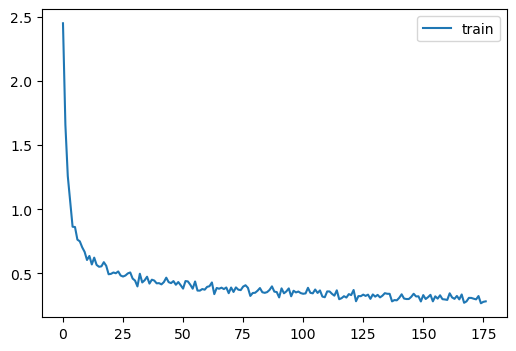

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

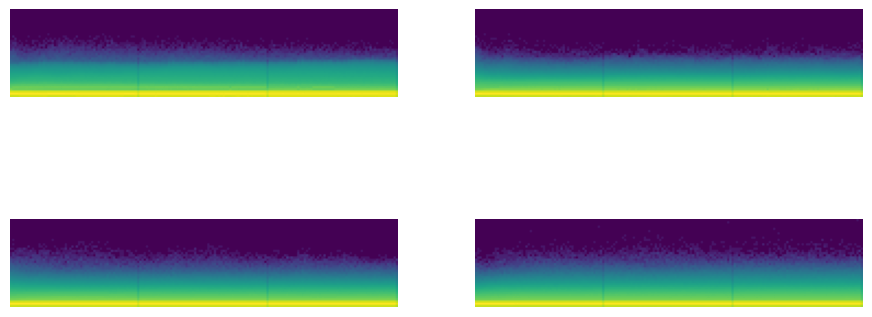

In [ ]:
astats.color_dim()

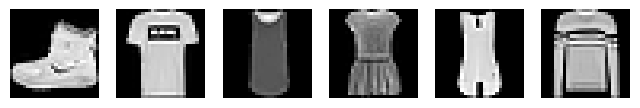

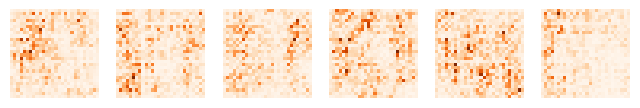

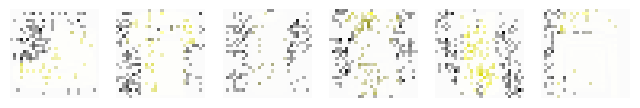

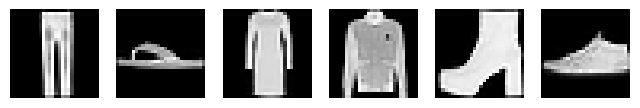

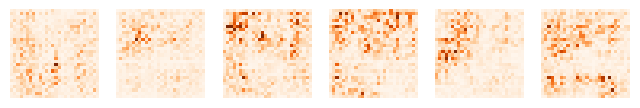

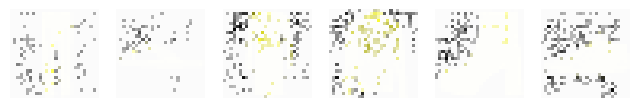

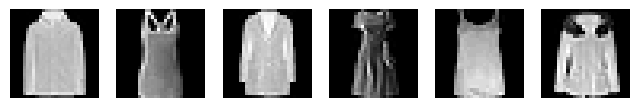

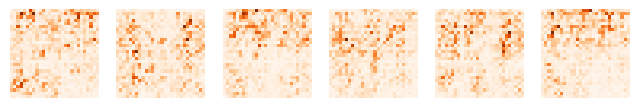

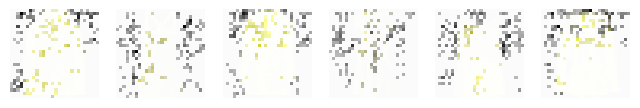

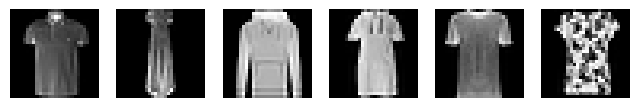

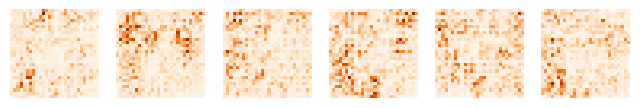

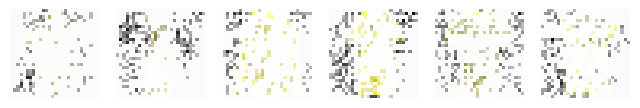

In [ ]:
show_saliency_maps(xb, learn.model,  max_n_batches=4, n_imgs=6, cmap='Oranges', abs_val=True)

### ResNet

In [ ]:
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    conv2 = conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks)
    if norm: init.constant_(conv2[1].weight, 0.)
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks), conv2)

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()

    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))

In [ ]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

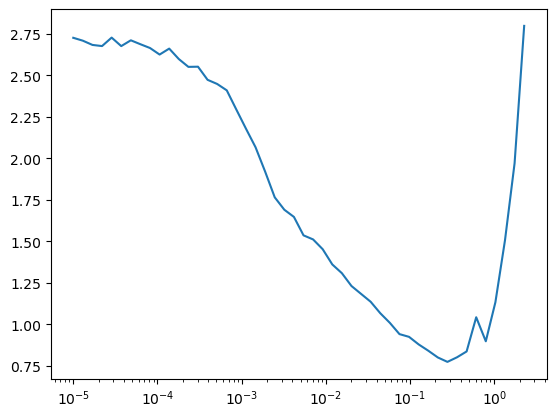

In [ ]:
model_resnet = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
MomentumLearner(model_resnet, dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

accuracy,loss,epoch,train
0.780,0.806,0,train
0.793,0.689,0,eval
0.877,0.394,1,train
0.860,0.395,1,eval
0.905,0.287,2,train
0.890,0.319,2,eval
0.928,0.214,3,train
0.919,0.244,3,eval
0.947,0.161,4,train
0.921,0.225,4,eval


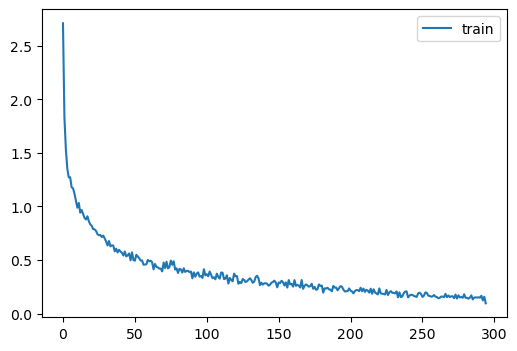

In [ ]:
lr = 2e-2
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model_resnet = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model_resnet, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

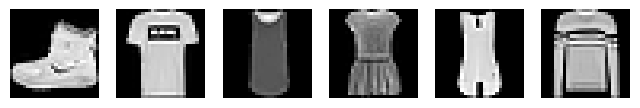

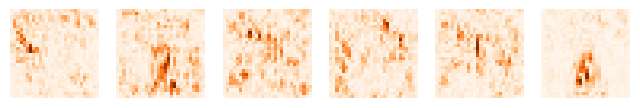

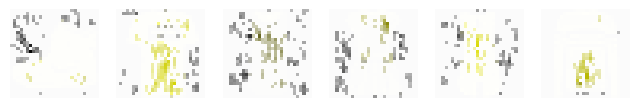

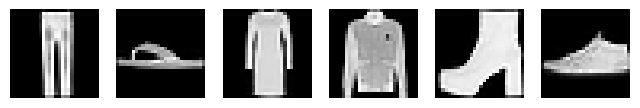

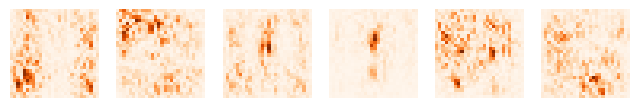

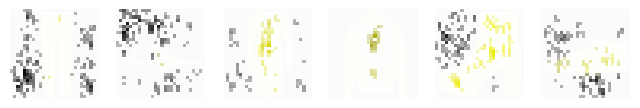

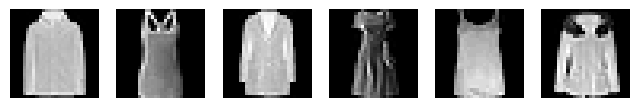

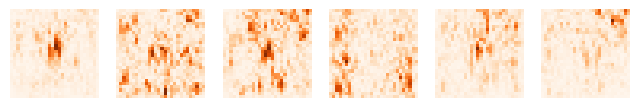

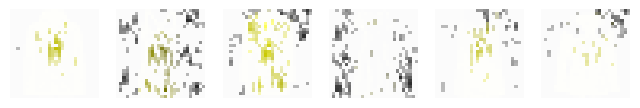

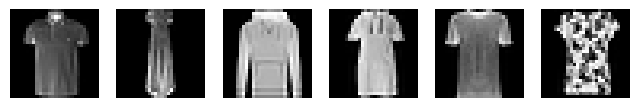

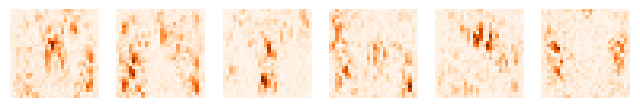

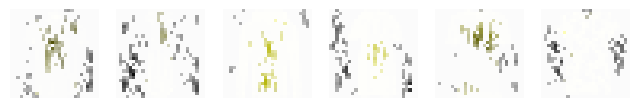

In [ ]:
show_saliency_maps(xb, model_resnet,  max_n_batches=4, n_imgs=6, cmap='Oranges', abs_val=True)

## Schedulers

We've already seen how we can easily write a custom LR-adjusting callback or `Learner`, or can use the predefined PyTorch schedulers. We'll use the predefined ones for now since there's nothing new to learn in implementing them ourselves.

In [ ]:
print(' \n'.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower()))

ChainedScheduler 
ConstantLR 
CosineAnnealingLR 
CosineAnnealingWarmRestarts 
Counter 
CyclicLR 
ExponentialLR 
LambdaLR 
LinearLR 
MultiStepLR 
MultiplicativeLR 
OneCycleLR 
Optimizer 
ReduceLROnPlateau 
SequentialLR 
StepLR


Another way to do the same, with filter, instead of a list comprehension. Use a lambda function for the filter function.

```python
filter(function or None, iterable) --> filter object

Return an iterator yielding those items of iterable for which function(item)
is true. If function is None, return the items that are true.
```

In [ ]:
' | '.join(filter(lambda x: x[0].isupper() and x[1].islower(), dir(lr_scheduler)))

'ChainedScheduler | ConstantLR | CosineAnnealingLR | CosineAnnealingWarmRestarts | Counter | CyclicLR | ExponentialLR | LambdaLR | LinearLR | MultiStepLR | MultiplicativeLR | OneCycleLR | Optimizer | ReduceLROnPlateau | SequentialLR | StepLR'

Experiment with CosineAnnealingLR

These work with pytorch optimisers, not our own miniai optimisers. Let's hack the learner:
- create a learning and run it with the cb SingleBatchCB
- fit (one batch)
- take the opt from the learner
- see its attributes and inspect it

In [ ]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [ ]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0]!='_')

'add_param_group defaults load_state_dict param_groups state state_dict step zero_grad'

In [ ]:
opt

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [ ]:
param = next(iter(learn.model.parameters()))
st = opt.state[param]

In [ ]:
len(opt.param_groups)

1

In [ ]:
pg = opt.param_groups[0]

In [ ]:
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

Experiment with Cosine Annealing.
- need to pass the optimizer to the scheduler class, so it knows to which optimizer it needs to apply different LR


In [ ]:
sched = lr_scheduler.CosineAnnealingLR(opt, T_max=100)

Scheduler will find the base LR from the optimizer

In [ ]:
opt.param_groups[0]['lr']

0.006

In [ ]:
sched.base_lrs

[0.006]

In [ ]:
sched.get_last_lr()

[0.006]

In [ ]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

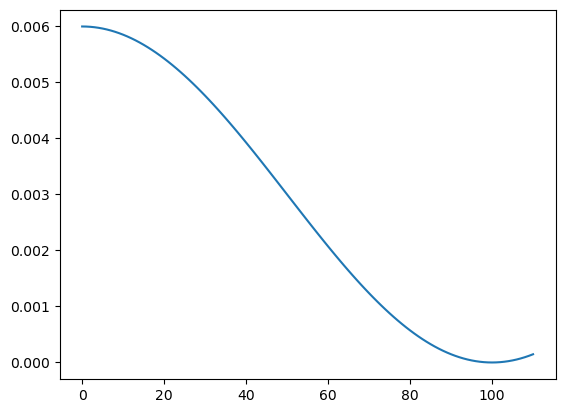

In [ ]:
sched_lrs(sched, 110)

### Scheduler callbacks

In [ ]:
#|export
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def step(self, learn):
        if learn.training: self.schedo.step()

In [ ]:
#|export
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self.step(learn)

In [ ]:
#|export
class HasLearnCB(Callback):
    def before_fit(self, learn): self.learn = learn 
    def after_fit(self, learn): self.learn = None

In [ ]:
#|export
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [ ]:
def _lr(cb): return cb.pg['lr']

In [ ]:
len(dls.train)

59

In [ ]:
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

accuracy,loss,epoch,train
0.809,0.515,0,train
0.858,0.382,0,eval
0.881,0.326,1,train
0.876,0.337,1,eval
0.899,0.279,2,train
0.883,0.316,2,eval


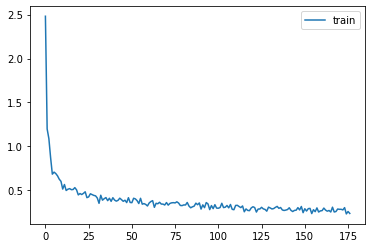

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

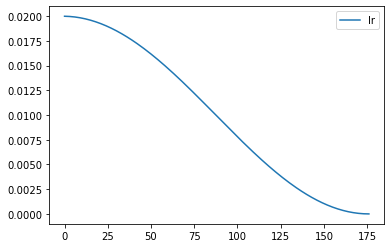

In [ ]:
rec.plot()

In [ ]:
#export
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self.step(learn)

accuracy,loss,epoch,train
0.809,0.517,0,train
0.859,0.380,0,eval
0.881,0.327,1,train
0.875,0.337,1,eval
0.899,0.275,2,train
0.887,0.307,2,eval


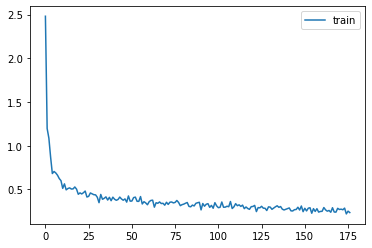

In [ ]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3)
set_seed(42)
xtra = [EpochSchedCB(sched),rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

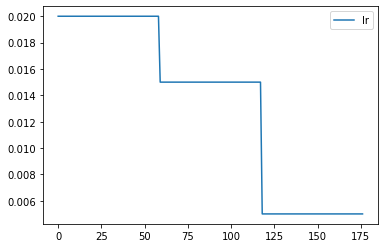

In [ ]:
rec.plot()

### 1cycle training

[Paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.

In [ ]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

0.765,0.662,0,train
0.821,0.569,0,eval
0.861,0.379,1,train
0.854,0.429,1,eval
0.888,0.302,2,train
0.886,0.323,2,eval
0.903,0.260,3,train
0.898,0.283,3,eval
0.922,0.214,4,train
0.903,0.271,4,eval


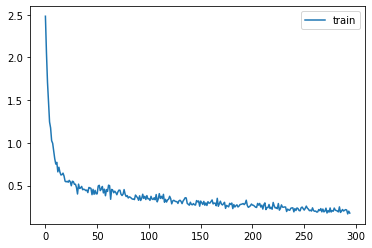

In [ ]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

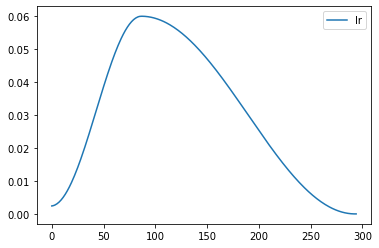

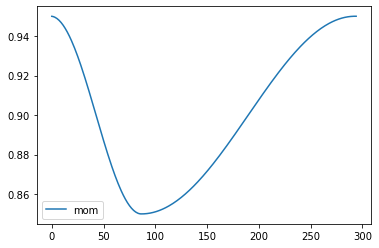

In [ ]:
rec.plot()

## Export -

In [ ]:
# import nbdev; nbdev.nbdev_export()